<h1>Compare Real and Complex Source Separation Performance</h1>
<h2>Michael A. Casey - Bregman Labs - Dartmouth College</h2>

In [2]:
from pylab import *
from bregman.suite import *
import cseparate as cs
from numpy.fft.fftpack import fft
from numpy.lib.function_base import hamming
import sys
%matplotlib inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
x,sr,fmt = wavread('amen.wav')

## Real and complex spectrum factorization and reconstruction

Reconstruct spectrum from real and complex components. Visualize the "error", either SqErr or KL2

In [24]:
def rc_sep(x, ncomps=9, nfft=4096, use_plca=True, normalize_reconstruction=True, **kwargs):
    """
    Take STFT of 1-D input signal, factorize magnitude-only and complex representations.
    inputs:
            x - 1D signal to separate
       ncomps - number of components to extract
         nfft - size (N) of FFT for STFT (W=N/2 and H=N/4) [4096]
     use_plca - whether to use PLCA or JADE for magnitude-only factorization [True]
     normalize_reconstruction - whether to normalize the reconstructed spectra [True]
     pre_emphasis - whether to apply pre-emphasis filter to spectrum for (C)JADE [True]
     svd_only  - whether to use SVD in place of JADE / CJADE [False]
    outputs:
        Xo - original STFT features
        Xr - magnitude-only ncomps STFT feature reconstruction
        Xc - complex ncomps STFT feature reconstruction
    """
    x = x - x.mean() # center the original signal
    x = x / abs(x).max() # normalize the original signal
    real_ncomps = ncomps 
    cmplx_ncomps = ncomps 
    N=nfft;W=N/2;H=N/4 # FFT parameters
    Xo = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
    oX = Xo.X # grab the real magnitude spectrum
    oX = feature_scale(oX, normalize=1) # ORIGINAL |STFT| normalized
    # REAL RECONSTRUCTION (normalized)
    Xr = LinearFrequencySpectrum(x, nfft=N, wfft=W, nhop=H)
    if use_plca:
        Xr.separate(cls=PLCA, n=real_ncomps) # real separation (PLCA)
        Xr.X = array(Xr.X_hat).sum(0)        
    else:
        xri, xr = cs.cseparate(x,cmplx_ncomps,N,H,W,magnitude_only=True, **kwargs) # JADE
        xr = xr-xr.mean() # center
        xr = xr/abs(xr).max() # normalize
        Xr = LinearFrequencySpectrum(xr, nfft=N, wfft=W, nhop=H)        
    # COMPLEX RECONSTRUCTION (normalized)
    xci, xc = cs.cseparate(x,cmplx_ncomps,N,H,W,**kwargs) # complex separation (CJADE)
    xc = xc-xc.mean() # center
    xc = xc/abs(xc).max() # normalize
    Xc = LinearFrequencySpectrum(xc, nfft=N, wfft=W, nhop=H)
    if normalize_reconstruction:
        Xo.X = feature_scale(Xo.X, normalize=True)
        Xr.X = feature_scale(Xr.X, normalize=True)
        Xc.X = feature_scale(Xc.X, normalize=True)    
    return Xo, Xr, Xc

# Symmetric Kullback Leibler Divergence
def kl2(p,q,plotting=False):
    """
    Return the summetric Kullback-Leibler divergence between distributions p and q
    KL2(P,Q) = { H(P,Q)-H(P) + H(Q,P)-H(Q) } / 2 
    """
    p = p.flatten()
    q = q.flatten()
    idx = where((p>0) & (q>0))
    p=p.copy()[idx]
    q=q.copy()[idx]
    p = p/p.sum()
    q = q/q.sum()
    if plotting:
        plot(p)
        plot(q)
        grid()
    a = -sum(p*log(q)) - -sum(p*log(p))
    b = -sum(q*log(p)) - -sum(q*log(q))
    return (a+b)/2

def sq_err(a,b):
    """
    Return the square error between matrices a and b
    """
    return (a - b)**2
    
def calc_error(Xa, Xb, use_kl2=True, reduce_error=False):
    """
    Calculate error between (complex) STFTs (no side-effect)
    inputs:
        Xa - original STFT
        Xb - magnitude only component reconstruction
        use_kl2 - whether to use KL2 (default) or SQERR [True]
    outputs:
        err - err_fun(Xa,Xb)
    """
    n = min(Xa.shape[1], Xb.shape[1])    
    if use_kl2:
        err = kl2(Xa[:,:n], Xb[:,:n])
    else:
        err = sq_err(Xa[:,:n], Xb[:,:n])
    if reduce_error:
        err = err.mean()
    return err

def calc_rc_errs(x, ncomps_l = range(2,13,4), **kwargs):
    real_err, cmplx_err = [], []
    print "iteration ncomps =",
    for k in ncomps_l:
        print k,
        sys.stdout.flush()
        Xo, Xr, Xc = rc_sep(x, ncomps=k, **kwargs)
        real_err.append( calc_error(Xo.X, Xr.X, reduce_error=True) )
        cmplx_err.append( calc_error(Xo.X, Xc.X, reduce_error=True) )
    return real_err, cmplx_err

def plot_results(ncomps_l, real_err, cmplx_err):
    # Plot the results of the experiment
    plot(ncomps_l, real_err,'-o')
    plot(ncomps_l, cmplx_err,'-o')
    title('Real versus Complex Components [nfft=4096]', fontsize=14)
    ylabel('Error / Divergence', fontsize=14)
    legend(['Real','Complex'])
    axis(xmin=1.9, ymax=max(max(real_err),max(cmplx_err))*1.2) # Autoscale y axis
    grid()

iteration ncomps = 2 6 10 iteration ncomps = 2 6 10 iteration ncomps = 2 6 10

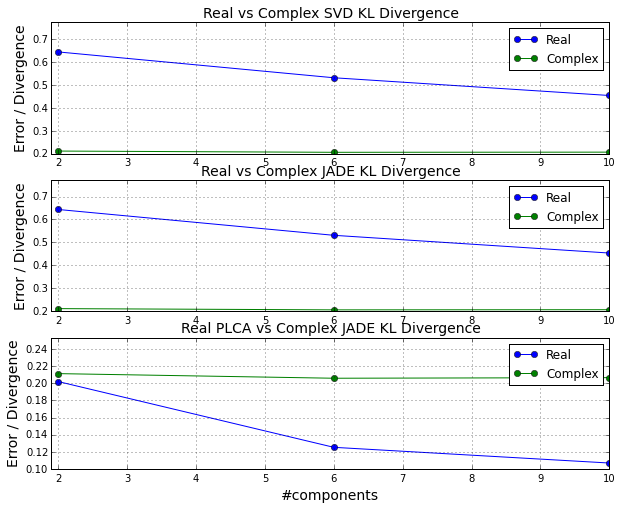

In [25]:
ncomps_l = range(2,13,4)
subplot(311)
real_err, cmplx_err = calc_rc_errs(x, ncomps_l, nfft=4096, use_plca=False, svd_only=True)
plot_results(ncomps_l, real_err, cmplx_err)
title('Real vs Complex SVD KL Divergence', fontsize=14)
subplot(312)
real_err, cmplx_err = calc_rc_errs(x, ncomps_l, nfft=4096, use_plca=False, svd_only=False)
plot_results(ncomps_l, real_err, cmplx_err)
title('Real vs Complex JADE KL Divergence', fontsize=14)
subplot(313)
real_err, cmplx_err = calc_rc_errs(x, ncomps_l, nfft=4096, use_plca=True, svd_only=True)
plot_results(ncomps_l, real_err, cmplx_err)
title('Real PLCA vs Complex JADE KL Divergence', fontsize=14)
xlabel('#components', fontsize=14)

In [74]:
reload(cs)
# Get reconsruction spectra for real and complex at given ncomps
Xo, Xr, Xc = rc_sep(x, ncomps=10, use_plca=True, svd_only=True, pre_emphasis=True, transpose_spectrum=True)

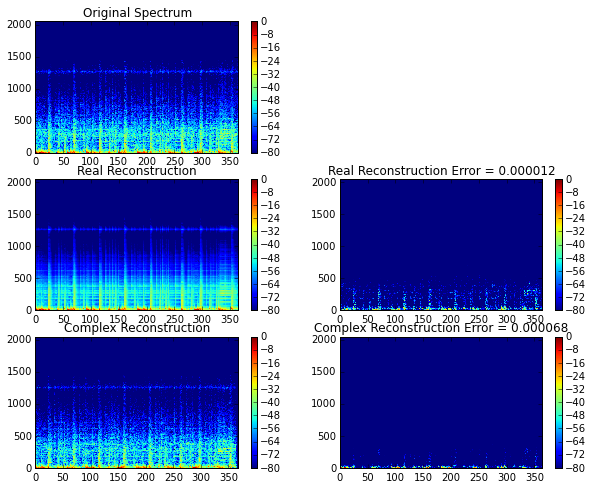

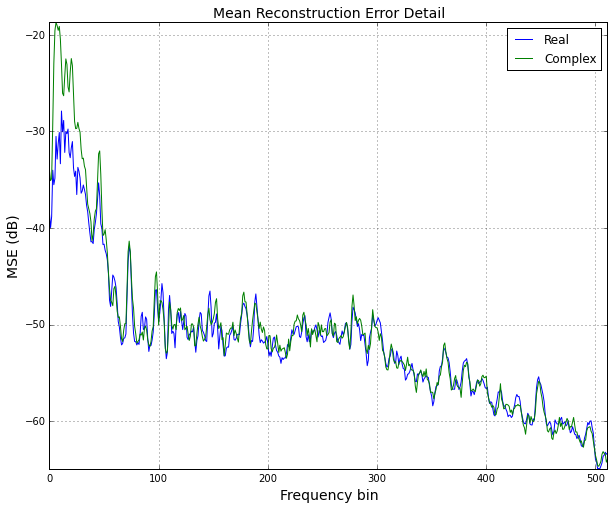

In [75]:
sqerr_real = calc_error(Xo.X, Xr.X, use_kl2=False, reduce_error=False)
sqerr_cmplx = calc_error(Xo.X, Xc.X, use_kl2=False, reduce_error=False)
subplot(321)
feature_plot(Xo.X,normalize=1,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Original Spectrum')
subplot(323)
feature_plot(Xr.X,normalize=1,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Real Reconstruction')
subplot(324)
feature_plot(sqerr_real,normalize=1,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Real Reconstruction Error = {:3f}'.format(sqerr_real.mean()))
subplot(325)
feature_plot(Xc.X,normalize=1,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Complex Reconstruction')
subplot(326)
feature_plot(sqerr_cmplx,normalize=1,dbscale=1,nofig=1,vmin=-80,vmax=0)
title('Complex Reconstruction Error = {:3f}'.format(sqerr_cmplx.mean()))
figure()
plot(10*log10(sqerr_real.mean(1))[:512])
plot(10*log10(sqerr_cmplx.mean(1))[:512])
title('Mean Reconstruction Error Detail',fontsize=14)
xlabel('Frequency bin',fontsize=14)
ylabel('MSE (dB)', fontsize=14)
axis('tight');grid();legend(['Real','Complex'])

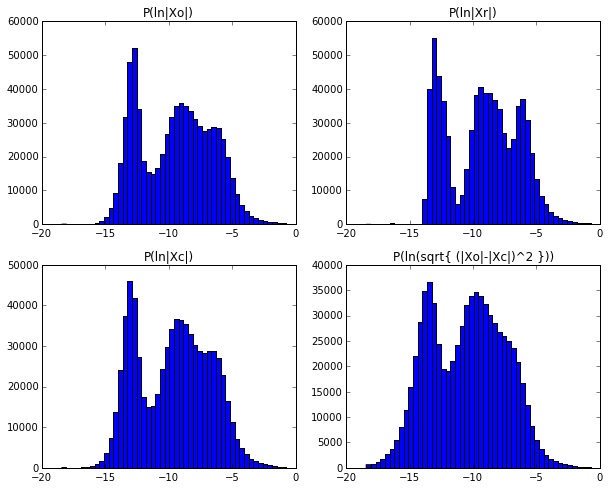

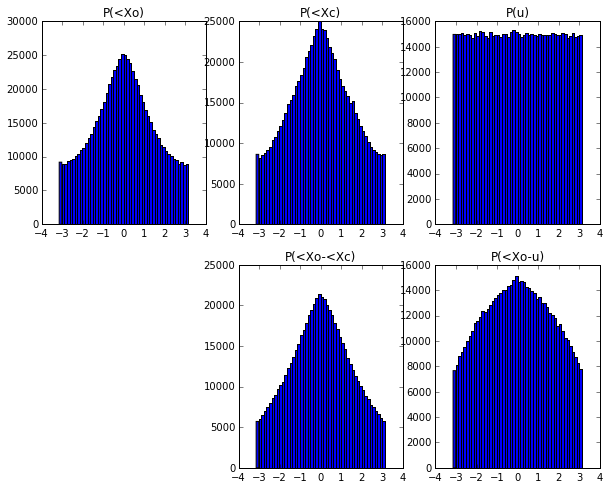

In [76]:
# Magnitude distribution
# oXh, cXh, dXh
n = min(Xo.X.shape[1],Xr.X.shape[1],Xc.X.shape[1])
oX, rX, cX = Xo.X[:,:n],Xr.X[:,:n],Xc.X[:,:n]
nbins=50
subplot(221)
idx = where((oX>0)&(rX>0)&(cX>0))
oXh=hist(log(oX[idx]).flatten(),nbins)
title('P(ln|Xo|)')
subplot(222)
rXh=hist(log(rX[idx]).flatten(),oXh[1])
title('P(ln|Xr|)')
subplot(223)
cXh=hist(log(cX[idx]).flatten(),oXh[1])
title('P(ln|Xc|)')
subplot(224)
dX = (oX[idx]-cX[:,:oX.shape[1]][idx])**2
dXh = hist(0.5*log(dX).flatten(),oXh[1])
title('P(ln(sqrt{ (|Xo|-|Xc|)^2 }))')

# Phase distribution
# oPh, cPh, dPh, nPh(NULL), dnPh
figure()
subplot(231)
Xo._phase_map()
oPh=hist(Xo.dPhi.flatten(),nbins)
title('P(<Xo)')
subplot(232)
Xc._phase_map()
cPh=hist(Xc.dPhi.flatten(),oPh[1])
title('P(<Xc)')
subplot(233)
dPhiNull = (rand(*Xo.STFT.shape)-0.5)*2*np.pi
nPh = hist(dPhiNull.flatten(),oPh[1])
title('P(u)')
subplot(235)
dp = Xo.dPhi-Xc.dPhi[:,:Xo.STFT.shape[1]]
dPh = hist(dp.flatten(),oPh[1])
title('P(<Xo-<Xc)')
subplot(236)
dn = Xo.dPhi-dPhiNull
dnPh = hist(dn.flatten(),oPh[1])
title('P(<Xo-u)')


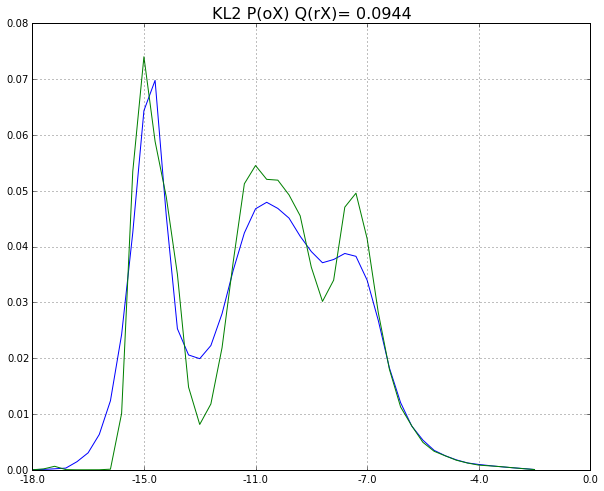

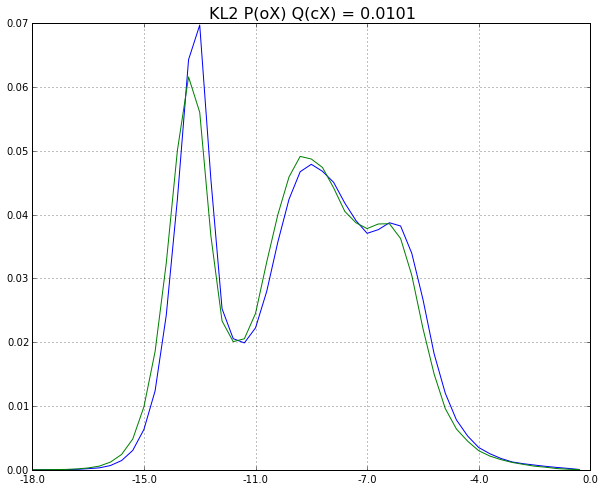

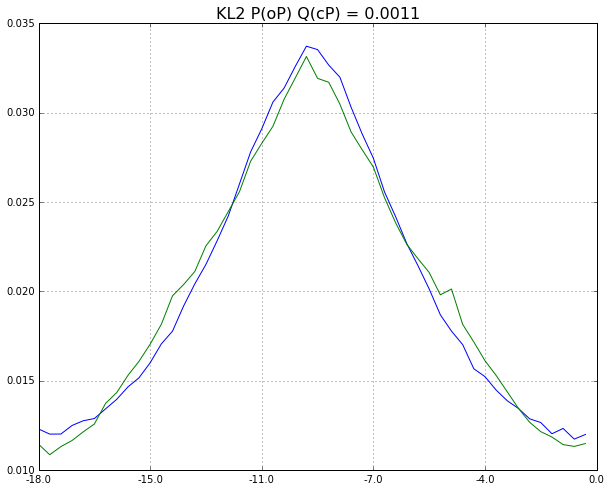

In [77]:
plotting=True
kl_r = kl2(oXh[0],rXh[0],plotting)
if plotting:
    xticks(arange(0,len(oXh[1]),10),oXh[1][::10].round())
    title('KL2 P(oX) Q(rX)= {:.4f}'.format(kl_r), fontsize=16)
    figure()
kl_c = kl2(oXh[0],cXh[0],plotting)
if plotting:
    xticks(arange(0,len(oXh[1]),10),oXh[1][::10].round())
    title('KL2 P(oX) Q(cX) = {:.4f}'.format(kl_c), fontsize=16)
    figure()
kl_p = kl2(oPh[0],cPh[0],plotting)
if plotting:
    xticks(arange(0,len(oXh[1]),10),oXh[1][::10].round())
    title('KL2 P(oP) Q(cP) = {:.4f}'.format(kl_p), fontsize=16)

## Cross-Entropy (KL2)


In [32]:
klr = [kl2(o,r) for o,r in zip(oX.T,rX.T)[:-2]]
klc = [kl2(o,c) for o,c in zip(oX.T,cX.T)[:-2]]

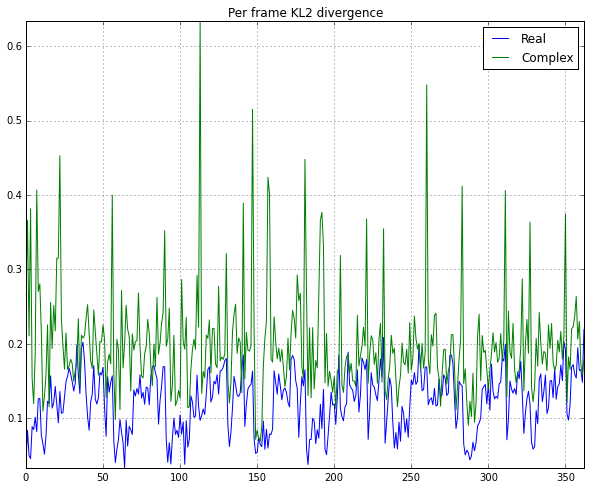

In [33]:
plot(klr);plot(klc)
axis('tight');grid()
title('Per frame KL2 divergence')
legend(['Real','Complex'])

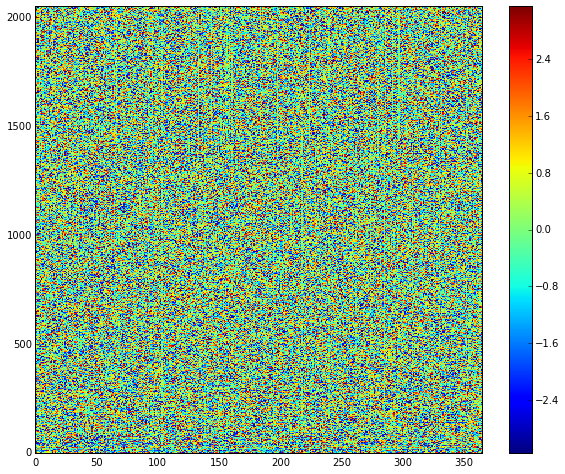

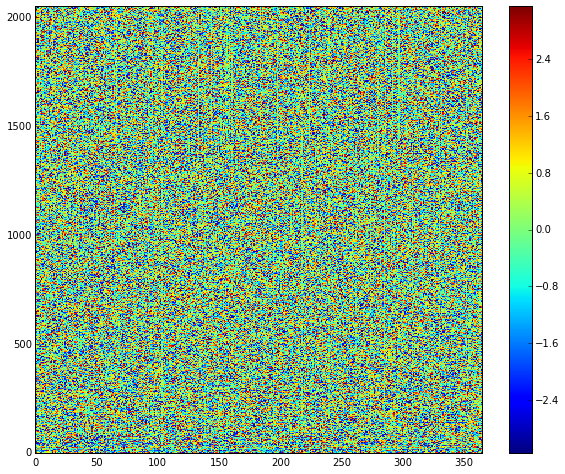

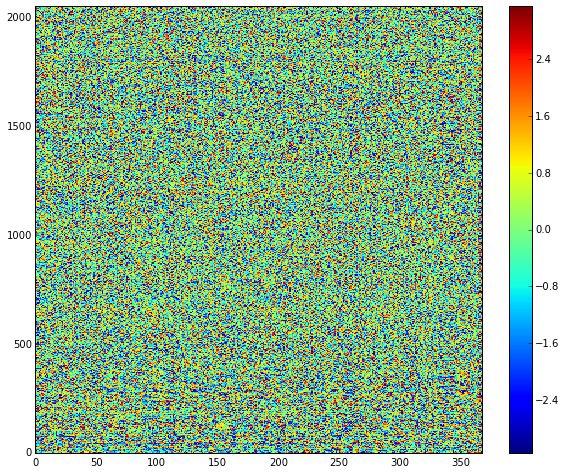

In [34]:
Xo._phase_map()
feature_plot(Xo.dPhi)

Xr._phase_map()
feature_plot(Xr.dPhi)

Xc._phase_map()
feature_plot(Xc.dPhi)



## Audio Reconstruction: Real (Random Phases) and Complex (Reconstructed Phases)

In [62]:
# Do this only once (I think)
Xr._phase_map()
Xr_Phi_hat = Xr._phase_rec((rand(*Xr.STFT.shape)-0.5)*np.pi)

In [63]:
# Real reconstruction
xr_hat = Xr.inverse(rX, Phi_hat=Xr_Phi_hat)
# Play the real reconstruction
play(balance_signal(xr_hat))

Period size is 64 , Buffer size is 22050


In [50]:
# Play the complex reconstruction
#cX.shape, Xc._phase_rec(Xc.dPhi).shape
#xc_hat = Xc.inverse(cX, Phi_hat=Xc._phase_rec(Xc.dPhi[:,:cX.shape[1]]),usewin=0)
xci, xc = cs.cseparate(x,10,4096,1024,2048,svd_only=True) # complex separation (CJADE) 

In [64]:
play(balance_signal(xc))

Period size is 64 , Buffer size is 22050


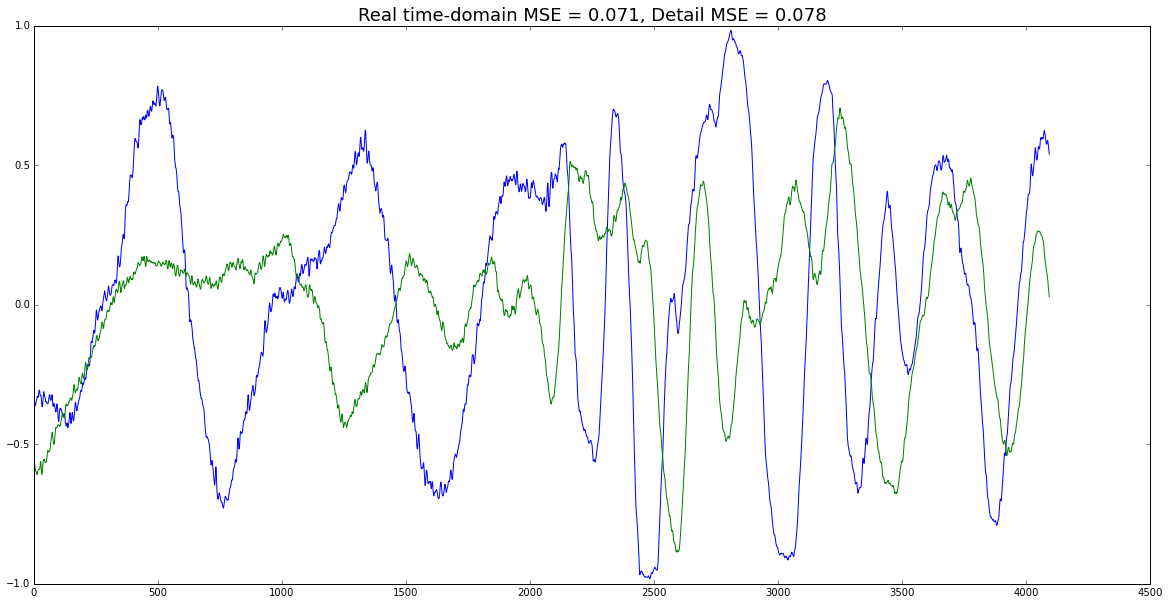

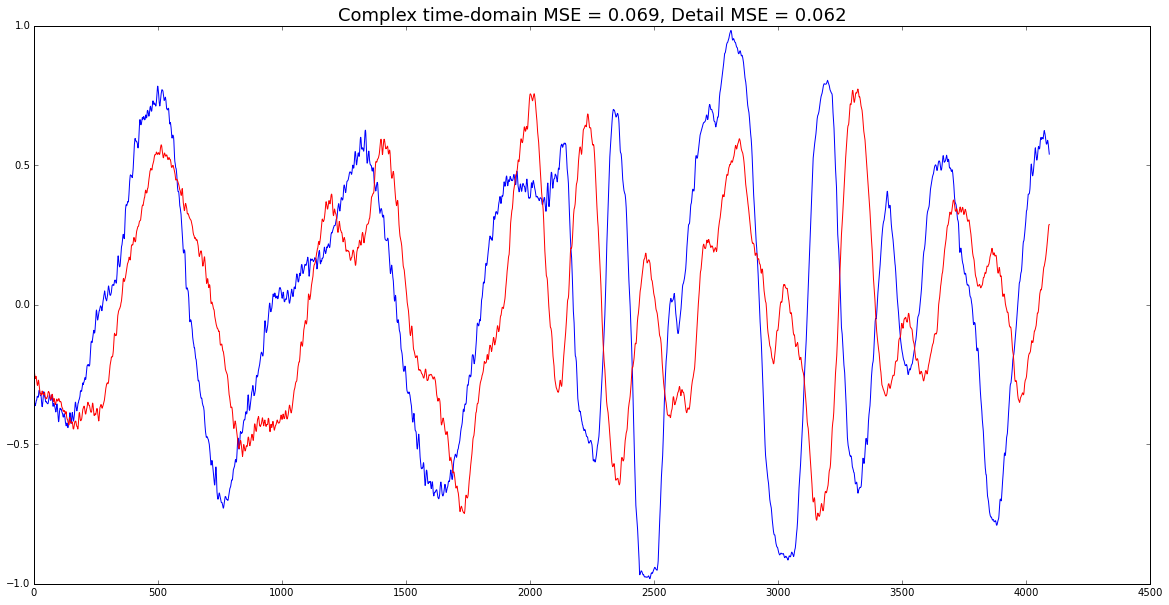

In [114]:
xr = (xr_hat - xr_hat.mean())[:len(x)]
xr = xr / abs(xr).max() 
xc = (xc - xc.mean())[:len(x)]
xc = xc / abs(xc).max()

R_mse = mean((xr-x)**2)
C_mse = mean((xc-x)**2)
r_mse = mean((xr[idx]-x[idx])**2)
c_mse = mean((xc[idx]-x[idx])**2)

f=figure(figsize=(20,10))
N=4096
offset=int(rand()*(len(x)-N))
idx = slice(offset,offset+N)
plot(x[idx])
plot(xr[idx])
title('Real time-domain MSE = {:.3f}, Detail MSE = {:.3f}'.format(R_mse, r_mse), fontsize=18)
f=figure(figsize=(20,10))
plot(x[idx])
plot(xc[idx],'r')
title('Complex time-domain MSE = {:.3f}, Detail MSE = {:.3f}'.format(C_mse, c_mse), fontsize=18)